In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/mnt/A46C400E6C3FDA2E/Python/Bitcoin/BTC-USD.csv').sort_values('Date')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


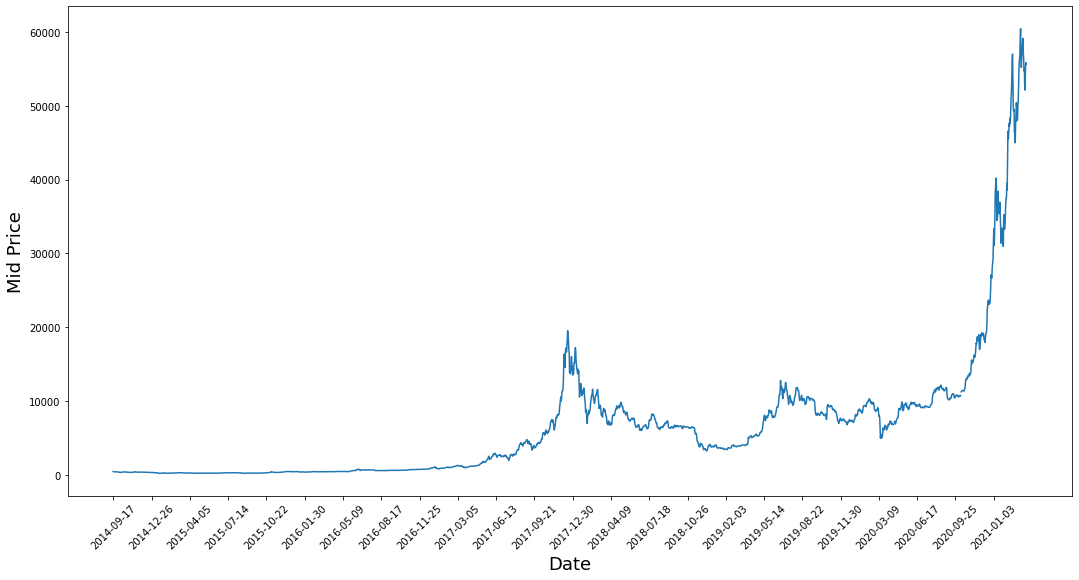

In [3]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],100),df['Date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [4]:
#First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,['High']].values
low_prices = df.loc[:,['Low']].values
mid_prices = (high_prices+low_prices)/2.0

In [5]:
#Split data to traing_data and test_data. 70% 30%
train_data = mid_prices[:int(len(mid_prices)*0.7)]
test_data = mid_prices[int(len(mid_prices)*0.7):]


In [6]:
print(train_data.shape)
print(test_data.shape)

(1670, 1)
(716, 1)


In [7]:
#Scale the data to be between 0 and 1
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [9]:
#Train the Scaler with training data and smooth data
smooth_window_size = 100
for di in range(0,1000, smooth_window_size):
    scaler.fit(train_data[di:di+smooth_window_size,:])
    train_data[di:di+smooth_window_size,:] = scaler.transform(train_data[di:di+smooth_window_size,:])

scaler.fit(train_data[di+smooth_window_size:,:])
train_data[di+smooth_window_size:,:] = scaler.transform(train_data[di+smooth_window_size:,:])

In [10]:
#Reshape both train and test data
train_data = train_data.reshape(-1)

#Normaize test data
test_data = scaler.transform(test_data).reshape(-1)

In [11]:
EMA = 0.0
gamma = 0.1

for ti in range(1670):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

all_mid_data = np.concatenate([train_data, test_data], axis=0)

In [18]:
window_size = 99
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.02590


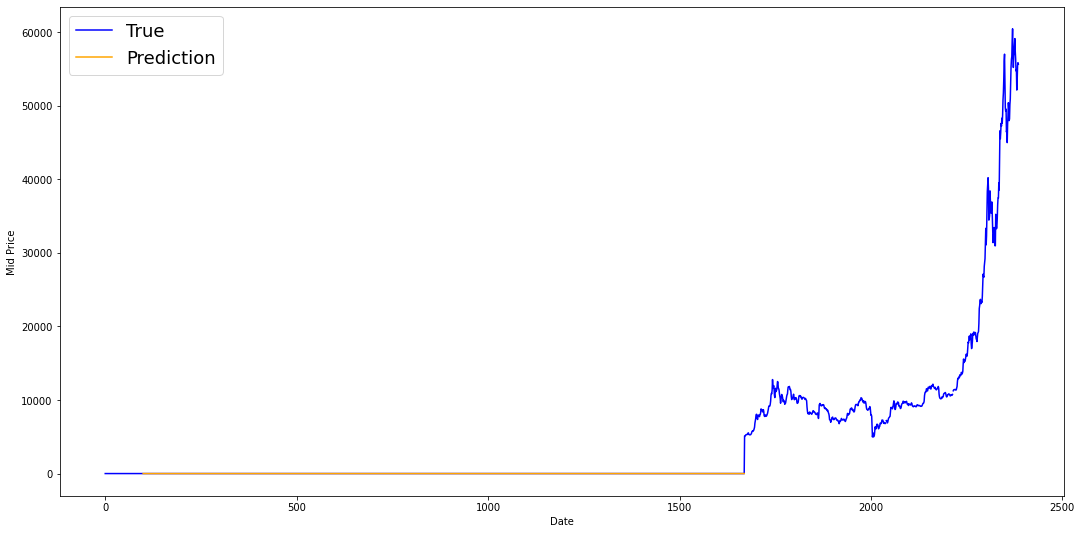

In [19]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [16]:
window_size = 99
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00062


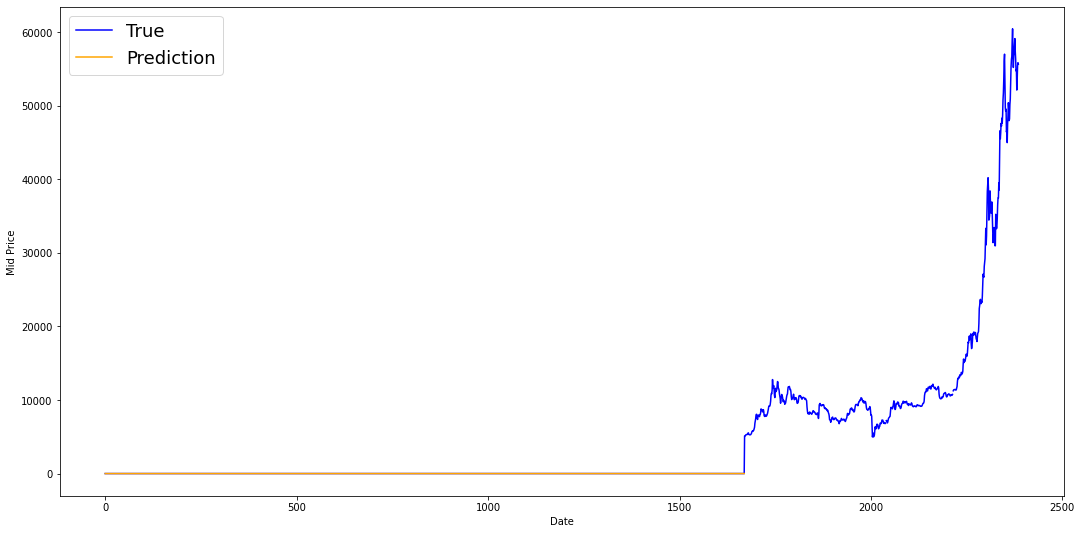

In [17]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()